In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib

molecule is [rapamycin](https://pubchem.ncbi.nlm.nih.gov/compound/rapamycin#section=2D-Structure)

In [3]:
rapamycin_SMILES = 'CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)CC(OC(=O)C3CCCCN3C(=O)C(=O)C1(O2)O)C(C)CC4CCC(C(C4)OC)O)C)C)O)OC)C)C)C)OC'
rapamycin_SMILES_isomeric = 'C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)C)/C)O)OC)C)C)/C)OC'

In [4]:
mol = Chem.rdmolfiles.MolFromSmiles(rapamycin_SMILES)
fig = Draw.MolToMPL(mol, size=(300, 300), wedgeBonds=True)

In [15]:
# finds maximum common substructure among list of molecule objects
def get_mcs(products_df):      # gets a df containing SMILES strings of products
    
    mol_list = list(products_df[0]) # converts product column to list

    for i in range(len(mol_list)): # converts SMILES strings to molecule objects
        mol_list[i] = Chem.MolFromSmiles(mol_list[i])

    maximum_common_substructure = rdFMCS.FindMCS(mol_list)
    
    return maximum_common_substructure

#Draw.MolToImage(maximum_common_substructure, size=(300, 300), kekulize=False, wedgeBonds=True)

maximal common substructure code

In [16]:
import pandas as pd
from rdkit.Chem import rdFMCS

In [17]:
# gets a df containing SMILES strings of products
df = pd.DataFrame([["C#CCP"],["C=CCO"]])
# converts product column to list
mol_list = list(df[0])

In [18]:
result = get_mcs(df)
type(result)

rdkit.Chem.rdFMCS.MCSResult

In [19]:
result.smartsString

'[#6]-[#6]'

In [20]:
Chem.MolFromSmarts(result)

TypeError: No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type MCSResult

In [9]:
type(mol)

rdkit.Chem.rdchem.Mol

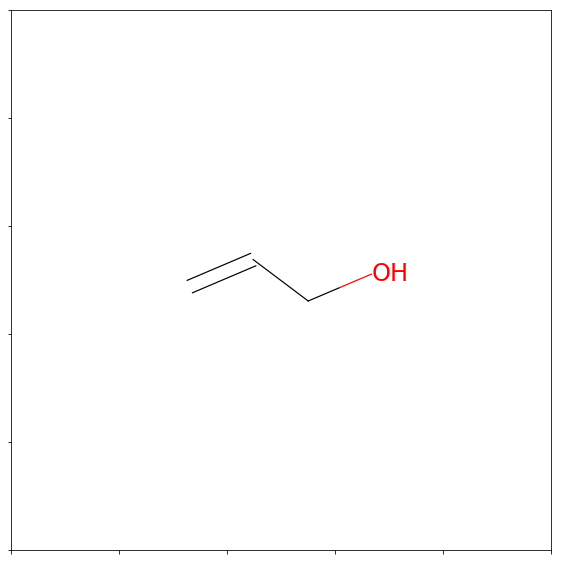

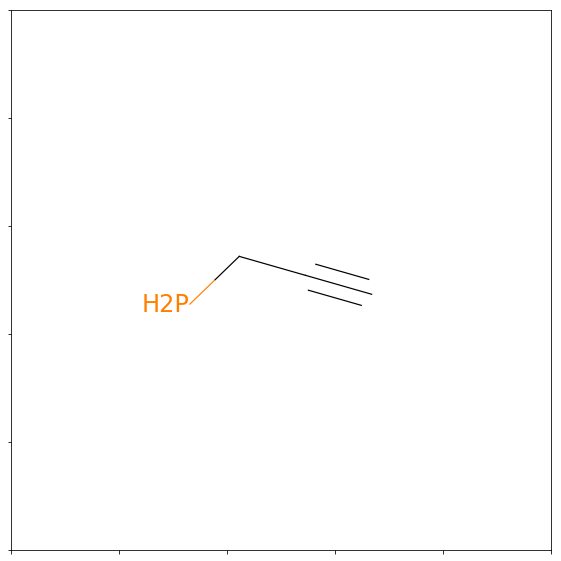

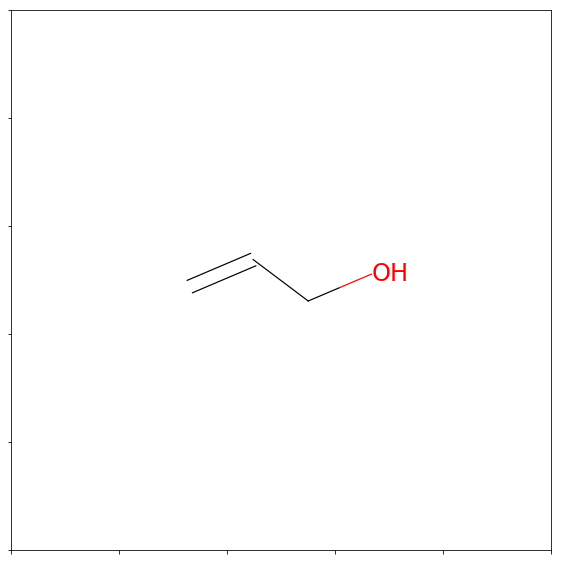

In [14]:
Draw.MolToMPL(mol_list[0])
Draw.MolToMPL(mol_list[1])

molecular similarity between maximal common substructure and each product

In [ ]:
with input as enzyme_products_df
    
    mcs = get_mcs(input)
    
    distance_list = []
    
    for index, row in input.itterrows():
        distance = #distance score to mcs
        distance_list.append(distance)
    
    return distance_list

average similarity value

In [43]:
def avg_similarity(distance_list):
    
    return sum(distance_list)/len(distance_list)